In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
import copy 
from redTools import *
from Kcorrect import *

from matplotlib import rcParams


In [2]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function
def makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='test'):

    fig = py.figure(figsize=(17, 5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax_list  = [ax1,ax2,ax3]
    x0 = 0.9*xlim[0]+0.1*xlim[1]
    y0 = 0.15*ylim[0]+0.85*ylim[1]    

    delta = y_trn-p_y_trn
    ax = ax_list[0]
    ax.plot(y_trn, delta, 'g.', alpha=0.3)
    ax.set_title('Training Set', fontsize=22)
    ax.set_ylabel(ylabel, fontsize=20)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=18, color='k')
    
    delta = y_cvl-p_y_cvl
    ax = ax_list[1]
    ax.plot(y_cvl, delta, 'r.', alpha=0.7)
    ax.set_title('Cross Validation Set', fontsize=22)
    plt.setp(ax.get_yticklabels(), visible=False)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=18, color='k')

    delta = y_tst-p_y_tst
    ax = ax_list[2]
    ax.plot(y_tst, delta, 'b.', alpha=0.7)
    ax.set_title('Test Set', fontsize=22)
    plt.setp(ax.get_yticklabels(), visible=False)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=18, color='k')

    for ax in ax_list:
        
        ax.set_xlabel(xlabel, fontsize=20)
        ax.plot(xlim, [0,0], 'k:')
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 


    plt.subplots_adjust(wspace=0.05)
#######################################

In [3]:
## loading data
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

Feature Importances:  [0.15268433 0.02980654 0.0638095  0.75369964]
g_r  --> 15.27%
r_i  --> 2.98%
i_z  --> 6.38%
pc0  --> 75.37%


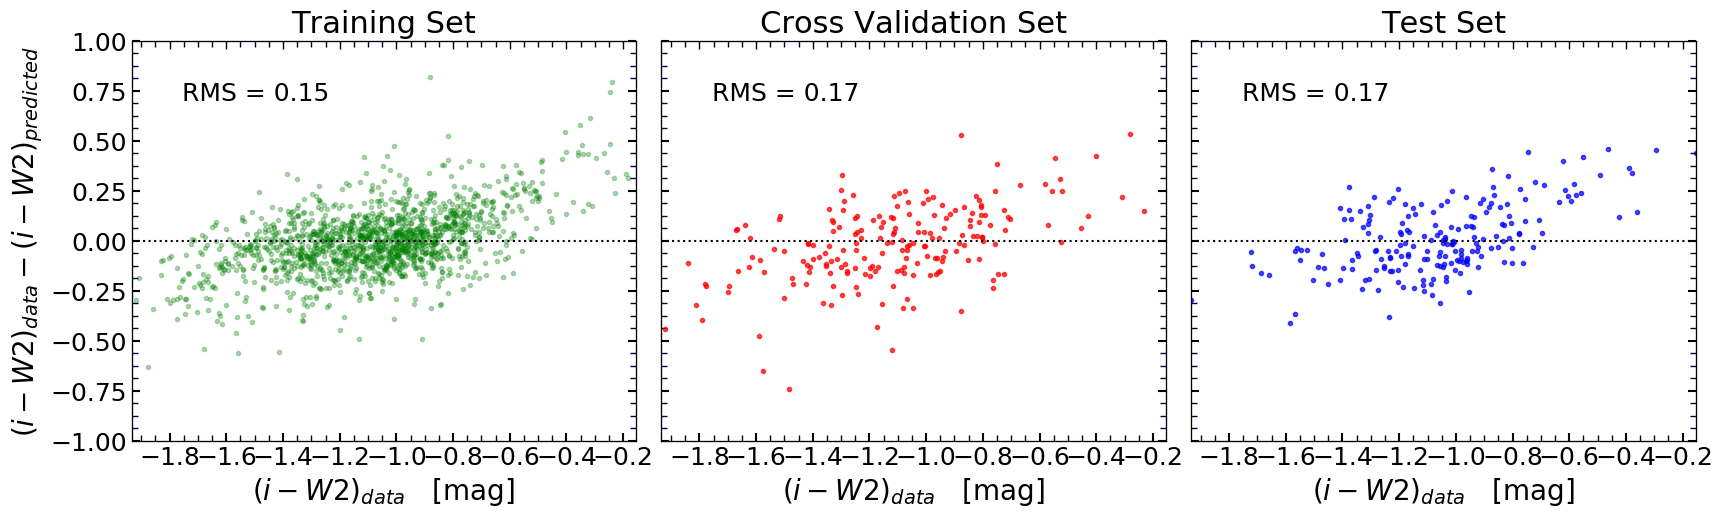

In [5]:
################################ Feature selection, regression parameters
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=200, N_test=200)
import pylab as py

################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'pc0']
output   = 'i_w2'
max_depth=9
n_estimators=8146
max_features=3 #len(features)
min_samples_leaf=14
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    print features[j], ' --> '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'i-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grI_mu50')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
[0.15132894 0.01301037 0.04483503 0.79132805]


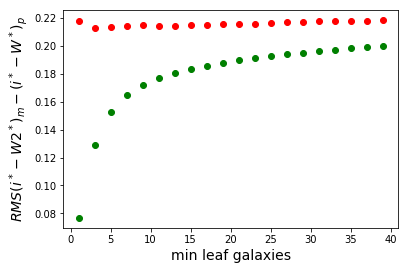

In [8]:
nLeaf = np.arange(1,40,2)
Seeds = range(20)
Stdev_trn = np.ones(shape = (len(nLeaf),len(Seeds)))
Stdev_cvl = np.ones(shape = (len(nLeaf),len(Seeds)))
importance = np.ones(shape = (len(Seeds),4))

for j in range(len(Seeds)):
    print j
    table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=Seeds[j])

    ################################ Feature selection, regression parameters
    features = ['g_r', 'r_i', 'i_z', 'pc0']
    output   = 'i_w2'
    n_estimators=10000
    max_depth = 10
    max_features=3
    bootstrap=True
    ################################ Regression (Random Forest)

    for k in range(len(nLeaf)):
        regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
            table_tst, table_cvl, table_trn, \
                features, output, \
                    max_features=max_features, min_samples_leaf=nLeaf[k], bootstrap=bootstrap)
        Stdev_cvl[k][j]  = np.std(y_cvl-p_y_cvl)
        Stdev_trn[k][j] = np.std(y_trn-p_y_trn)
        importance[j] = regr.feature_importances_.T

plt.plot(nLeaf, np.median(Stdev_cvl,1), 'ro')
plt.plot(nLeaf, np.median(Stdev_trn,1), 'go')
plt.xlabel('min leaf galaxies',fontsize=14)
plt.ylabel(r'$RMS (i^*-W2^*)_m-(i^*-W^*)_p$',fontsize=14)
print np.median(importance.T,1)

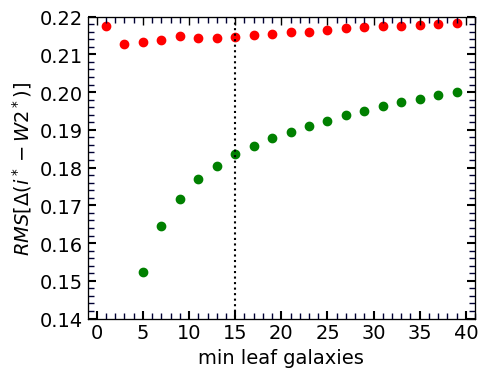

In [9]:
Stdev_cvl0 = copy.deepcopy(Stdev_cvl)
Stdev_trn0 = copy.deepcopy(Stdev_trn)

fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

ax.plot(nLeaf, np.median(Stdev_cvl0,1), 'ro')
ax.plot(nLeaf, np.median(Stdev_trn0,1), 'go')
ax.set_xlabel('min leaf galaxies',fontsize=14)
ax.set_ylabel(r'$RMS [\Delta(i^*-W2^*)]$',fontsize=14)

ax.plot([15,15],[0,20],'k:')

set_axes([ax], [-1,41], [0.14,0.22])